<div align="center" style="margin: 5px 0; font-size: 12px">

## MẠNG NEURON VECTOR TỰ HỒI QUY KẾT HỢP VỚI
##  THUẬT TOÁN DI TRUYỀN DÙNG TRONG DỰ BÁO

</div>


### Mục lục

#### 1. Cài đặt và Import Thư viện

#### 2. Đọc và Chuẩn bị Dữ liệu

#### 3. Tiền xử lý dữ liệu
- 3.1. Kiểm tra các giá trị thiếu
- 3.2. Lọc dữ liệu trong khoảng thời gian mong muốn

#### 4. Kiểm tra chuỗi dừng và phương sai
- 4.1. Biến đổi log để ổn định phương sai
- 4.2. Kiểm tra tính dừng và phương sai sau khi differencing

#### 5. Chia ra tập train/test
> *Với validation chia trong tập train*

#### 6. Xác định độ trễ (lag) tối ưu cho mô hình VAR
- 6.1. Kiểm tra hiệu suất với các độ trễ khác nhau: 10, 2, 4
- 6.2. So sánh tìm ra độ trễ tốt nhất

#### 7. Tối ưu hóa siêu tham số
- 7.1. Chuẩn bị dữ liệu cho LSTM
- 7.2. Thiết lập giải thuật di truyền (GA)
- 7.3. Thực hiện chạy GA để tối ưu hóa và tìm siêu tham số tốt nhất

#### 8. Huấn luyện mô hình VARNN
- 8.1. Xây dựng mô hình LSTM từ siêu tham số tối ưu từ GA
- 8.2. Huấn luyện mô hình với toàn bộ tập train
- 8.3. Tính toán chỉ số RMSE, MAE, MSE của VAR_LSTM_GA
- 8.4. Xây dựng mô hình LSTM từ tham số mặc định
- 8.5. Tính toán chỉ số RMSE, MAE, MSE của VAR_LSTM

#### 9. So sánh mô hình VAR_LSTM_GA với VAR_LSTM
- 9.1. Biểu đồ so sánh
- 9.2. Kết luận so sánh

#### 10. Dự đoán giá Bitcoin
- 10.1. Phục hồi giá trị dự đoán về dạng gốc
- 10.2. Biểu đồ dự đoán giá
- 10.3. In giá trị dự đoán cho Open, High, Low, Close

---
*© 2024 - Developed by:*  
**Trần Quốc Phúc - 21110608**  
**Đỗ Huỳnh Gia Khang - 21110891**

### 1. Cài đặt và Import Thư viện

In [1]:
import random
import math
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf  
from statsmodels.stats.diagnostic import het_breuschpagan
from deap import base, creator, tools
from statsmodels.tools import add_constant

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')


### 2. Đọc và Chuẩn bị Dữ liệu


In [2]:
# Đọc dữ liệu từ tệp CSV
maindf = pd.read_csv(r"F:\Nam4Ki1\TLCN\BTC-USD.csv", parse_dates=['Date'], index_col='Date')

In [3]:
print(maindf.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [4]:
print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])

Total number of days present in the dataset:  2713
Total number of fields present in the dataset:  6


In [5]:
maindf.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [6]:
maindf.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2713 entries, 2014-09-17 to 2022-02-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2713 non-null   float64
 1   High       2713 non-null   float64
 2   Low        2713 non-null   float64
 3   Close      2713 non-null   float64
 4   Adj Close  2713 non-null   float64
 5   Volume     2713 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 148.4 KB


In [7]:
maindf.describe()


,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


### 3. Tiền xử lý dữ liệu

#### 3.1. Kiểm tra các giá trị thiếu

In [8]:
print('Null Values:',maindf.isnull().values.sum())


Null Values: 0


In [9]:
print('NA values:',maindf.isnull().values.any())


NA values: False


In [10]:
#Hình dạng cuối cùng của tập dữ liệu sau khi xử lý các giá trị null

maindf.shape

(2713, 6)

#### 3.2. Lọc dữ liệu trong khoảng thời gian mong muốn 


In [11]:
# Lọc dữ liệu trong khoảng thời gian mong muốn và chọn các cột 'Open', 'High', 'Low', 'Close'
filtered_df = maindf[maindf.index > '2021-02-19']
dfOneYear = filtered_df[['Open', 'High', 'Low', 'Close']]

In [12]:
dfOneYear.head()

,Open,High,Low,Close
Date,,,,
2021-02-20,55887.335938,57505.226563,54626.558594,56099.519531
2021-02-21,56068.566406,58330.570313,55672.609375,57539.945313
2021-02-22,57532.738281,57533.390625,48967.566406,54207.320313
2021-02-23,54204.929688,54204.929688,45290.589844,48824.425781
2021-02-24,48835.085938,51290.136719,47213.500000,49705.332031


In [13]:
dfOneYear.shape

(365, 4)

### 4. Kiểm tra chuỗi dừng và phương sai 

In [14]:
# Kiểm tra chuỗi dừng với ADF test
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    for column in data.columns:
        result = adfuller(data[column])
        print(f"Kiểm tra ADF cho {column}:")
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f"Số bậc trễ: {result[2]}")
        print(f"Số quan sát được dùng: {result[3]}")
        print("Critical Values:")
        for key, value in result[4].items():
            print(f"   {key}: {value}")
        if result[1] > 0.05:
            print(f"{column} không phải là chuỗi dừng.\n")
        else:
            print(f"{column} là chuỗi dừng.\n")

        # Vẽ đồ thị để kiểm tra trực quan
        plt.figure(figsize=(10, 4))
        plt.plot(data[column])
        plt.title(f"Biểu đồ của {column}")
        plt.show()

In [15]:
# Kiểm tra phương sai không đổi bằng Breusch-Pagan test
def check_heteroscedasticity(data):
    for column in data.columns:
        residuals = data[column] - data[column].mean()

        # Thêm một cột hằng số (constant) vào dữ liệu
        exog = add_constant(data)  # Thêm cột hằng số

        # Kiểm tra phương sai không đổi với Breusch-Pagan test
        bp_test = het_breuschpagan(residuals, exog)
        
        print(f"Kết quả kiểm tra phương sai không đổi cho {column}:")
        print(f"Statistic: {bp_test[0]}")
        print(f"p-value: {bp_test[1]}")
        if bp_test[1] > 0.05:
            print(f"{column} có phương sai không đổi.\n")
        else:
            print(f"{column} có phương sai không đổi không.\n")

In [16]:
# Kiểm tra chuỗi dừng sau mỗi lần differencing
def check_stationarity_after_diff(data):
    for column in data.columns:
        series = data[column]
        order = 1
        max_order = 3  # Giới hạn số lần differencing
        
        while order <= max_order:
            # Kiểm tra ADF test
            result = adfuller(series)
            
            print(f"\nKiểm tra tính dừng cho {column} sau {order} lần differencing:")
            print(f'ADF Statistic: {result[0]}')
            print(f'p-value: {result[1]}')
            print('Critical values:')
            for key, value in result[4].items():
                print(f'\t{key}: {value}')
                
            if result[1] < 0.05:
                print(f"Chuỗi {column} đã dừng sau {order} lần differencing")
                break
                
            order += 1
            series = series.diff().dropna()
            
            if order > max_order:
                print(f"Chuỗi {column} không đạt tính dừng sau {max_order} lần differencing")

In [17]:
# Kiểm tra tính dừng và phương sai không đổi
def check_data_stationarity_and_heteroscedasticity(data):
    # Kiểm tra tính dừng
    check_stationarity(data)
    # Kiểm tra phương sai không đổi
    check_heteroscedasticity(data)
    # Kiểm tra bậc sai phân
    check_stationarity_after_diff(data)

#### 4.1. Biến đổi log để ổn định phương sai 


In [18]:
df_log_transformed = np.log(dfOneYear + 1)  # tránh log(0)

In [19]:
# Áp dụng phép differencing
df_log_diff = df_log_transformed.diff().dropna()


In [20]:
def check_data_stationarity_and_heteroscedasticity(data):
    # Phân tích cho từng cột
    for column in data.columns:
        # Tạo figure mới cho mỗi cột
        plt.figure(figsize=(12, 6))
        
        # Tính rolling statistics với window lớn hơn và thêm min_periods
        window_size = 30  # Tăng kích thước cửa sổ
        rolling_mean = data[column].rolling(window=window_size, min_periods=1, center=True).mean()
        rolling_std = data[column].rolling(window=window_size, min_periods=1, center=True).std()
        
        # Làm mượt thêm bằng exponential weighted moving average
        rolling_mean = rolling_mean.ewm(span=20, adjust=False).mean()
        rolling_std = rolling_std.ewm(span=20, adjust=False).mean()
        
        # Vẽ biểu đồ
        plt.plot(data[column], label='Original', alpha=0.5, color='blue')
        plt.plot(rolling_mean, label='Rolling Mean', color='red', linewidth=2)
        plt.plot(rolling_std, label='Rolling Std', color='green', linewidth=2)
        plt.title(f'Phân tích tính dừng cho {column}')
        plt.xlabel('Thời gian')
        plt.ylabel('Giá trị')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # In các thống kê
        print(f"\nThống kê cho {column}:")
        print(f"Mean: {data[column].mean():.4f}")
        print(f"Std: {data[column].std():.4f}")
        
        # Kiểm định ADF
        result = adfuller(data[column])
        print(f"\nKiểm tra ADF cho {column}:")
        print(f'ADF Statistic: {result[0]:.4f}')
        print(f'p-value: {result[1]:.4f}')
        print("Critical values:")
        for key, value in result[4].items():
            print(f'\t{key}: {value:.4f}')
        
        # Kết luận
        if result[1] > 0.05:
            print(f"=> {column} KHÔNG là chuỗi dừng (p-value > 0.05)")
            print("   Mean và std có thể thay đổi theo thời gian")
        else:
            print(f"=> {column} là chuỗi dừng (p-value < 0.05)")
            print("   Mean và std tương đối ổn định")
        
        plt.tight_layout()
        plt.show()  # Hiển thị biểu đồ cho cột hiện tại
        print("\n" + "="*50)  # Thêm dòng phân cách giữa các cột

#### 4.2. Kiểm tra tính dừng và phương sai sau khi differencing



Thống kê cho Open:
Mean: -0.0009
Std: 0.0390

Kiểm tra ADF cho Open:
ADF Statistic: -20.0812
p-value: 0.0000
Critical values:
	1%: -3.4485
	5%: -2.8695
	10%: -2.5710
=> Open là chuỗi dừng (p-value < 0.05)
   Mean và std tương đối ổn định


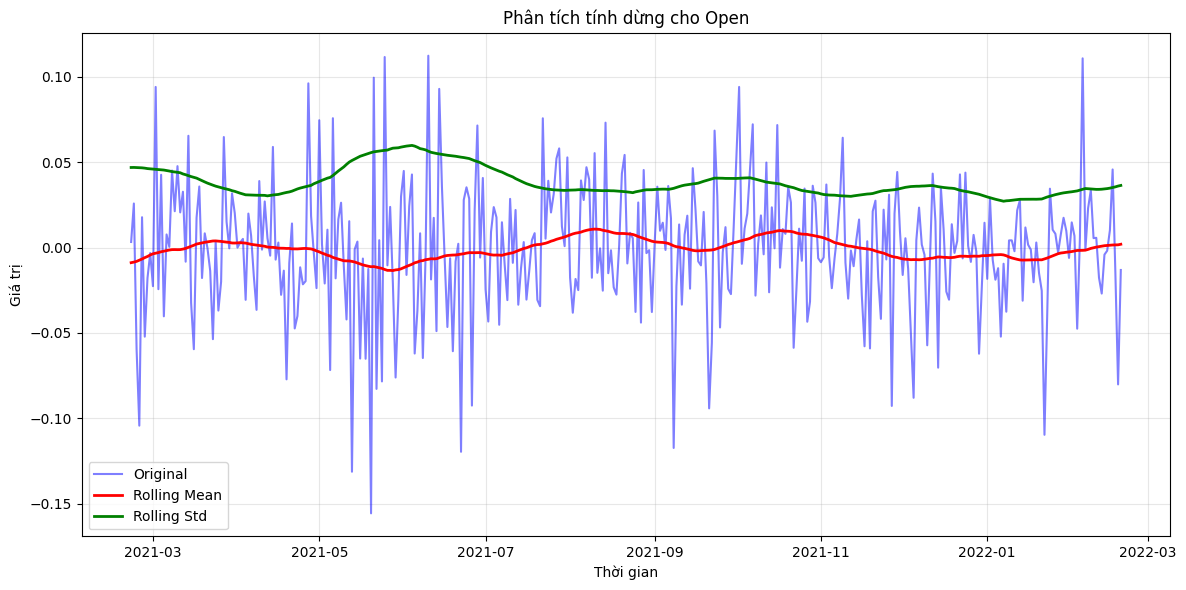



Thống kê cho High:
Mean: -0.0010
Std: 0.0322

Kiểm tra ADF cho High:
ADF Statistic: -17.6001
p-value: 0.0000
Critical values:
	1%: -3.4485
	5%: -2.8695
	10%: -2.5710
=> High là chuỗi dừng (p-value < 0.05)
   Mean và std tương đối ổn định


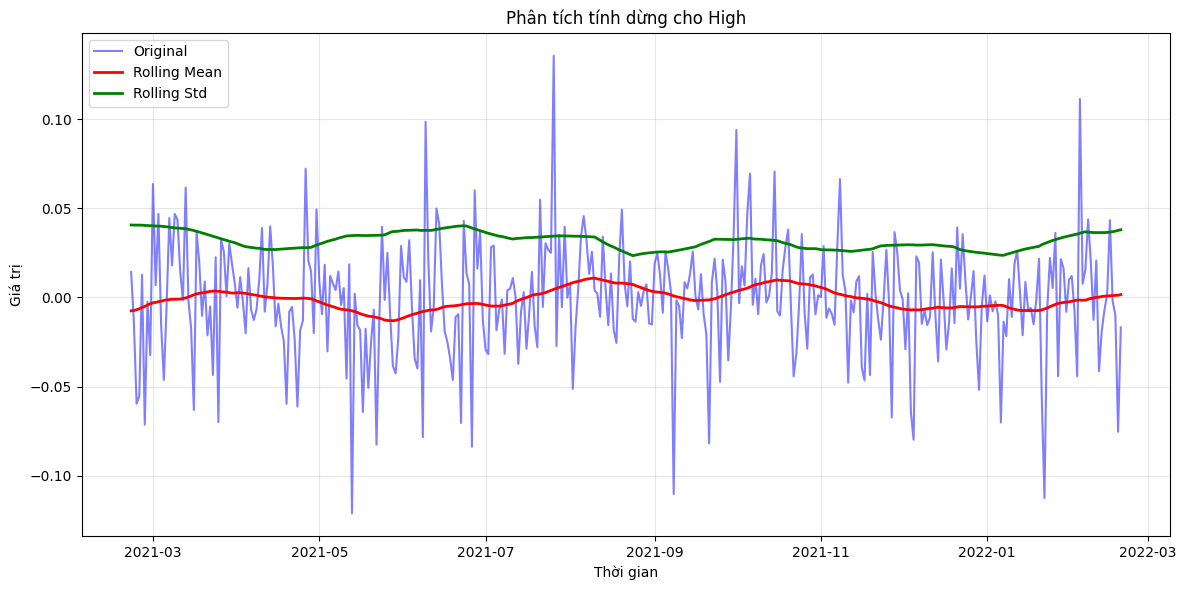



Thống kê cho Low:
Mean: -0.0009
Std: 0.0437

Kiểm tra ADF cho Low:
ADF Statistic: -9.0055
p-value: 0.0000
Critical values:
	1%: -3.4486
	5%: -2.8696
	10%: -2.5711
=> Low là chuỗi dừng (p-value < 0.05)
   Mean và std tương đối ổn định


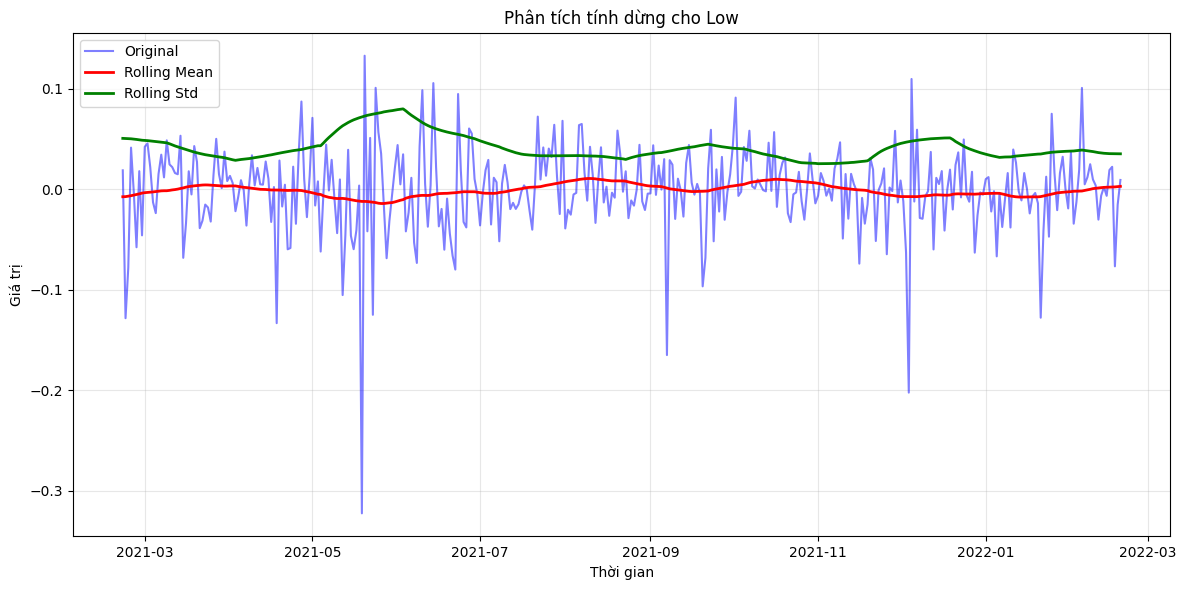



Thống kê cho Close:
Mean: -0.0009
Std: 0.0388

Kiểm tra ADF cho Close:
ADF Statistic: -20.0072
p-value: 0.0000
Critical values:
	1%: -3.4485
	5%: -2.8695
	10%: -2.5710
=> Close là chuỗi dừng (p-value < 0.05)
   Mean và std tương đối ổn định


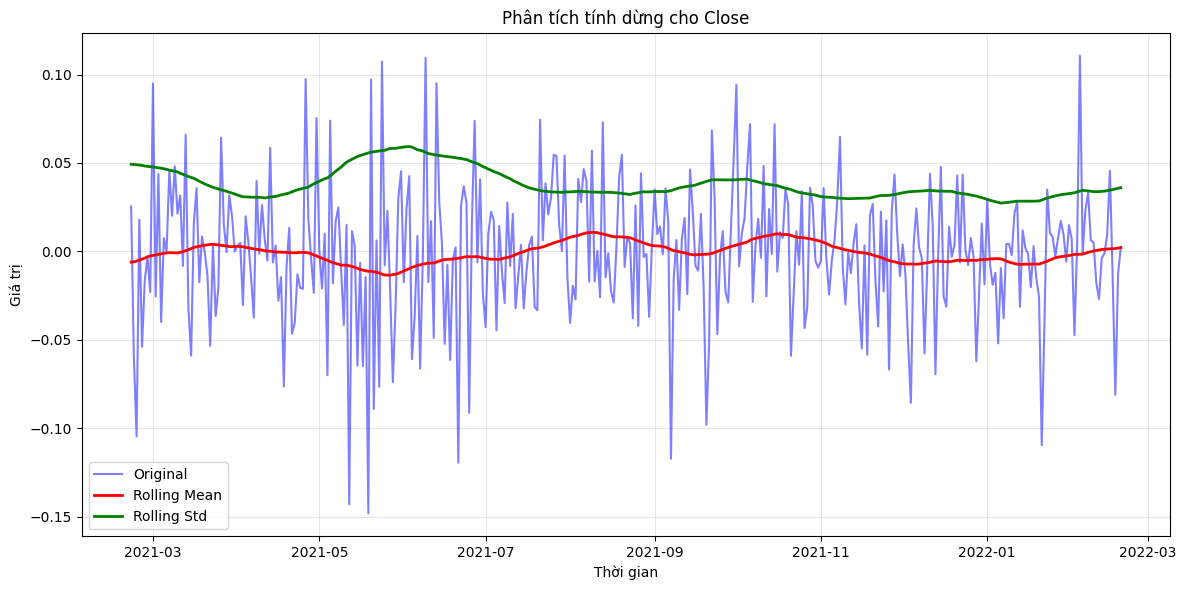

In [21]:
check_data_stationarity_and_heteroscedasticity(df_log_diff)

### 5. Chia ra tập train/test(với validation chia trong tập train)

Kích thước các tập:
Tổng số mẫu: 364
Train: 233 mẫu (64.0%)
Validation: 58 mẫu (15.9%)
Test: 73 mẫu (20.1%)

Kiểm tra tính liên tục:
Train end date: 2021-10-11 00:00:00
Valid start date: 2021-10-12 00:00:00
Valid end date: 2021-12-08 00:00:00
Test start date: 2021-12-09 00:00:00


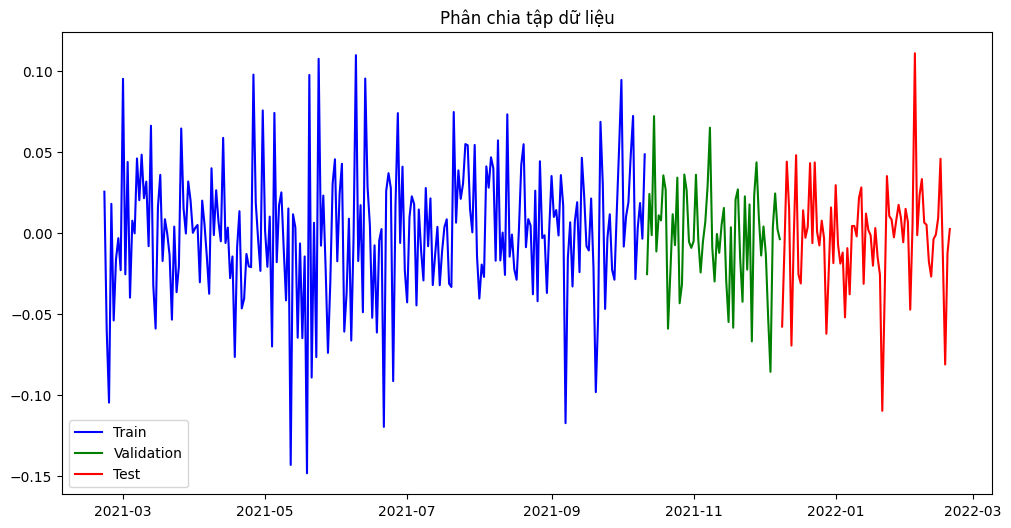

In [22]:
# Xác định tỷ lệ chia
TRAIN_RATIO = 0.8  # 80% cho train_full
TEST_RATIO = 0.2   # 20% cho test
VALID_RATIO = 0.2  # 20% của train_full cho validation

# Chia dữ liệu thành train_full và test
total_samples = len(df_log_diff)
train_size = int(total_samples * TRAIN_RATIO)
test_size = total_samples - train_size

train_data_full = df_log_diff[:train_size]
test_data = df_log_diff[train_size:]

# Chia train_full thành train và validation
valid_size = int(len(train_data_full) * VALID_RATIO)
train_data = train_data_full[:-valid_size]  # 80% đầu của train_full
valid_data = train_data_full[-valid_size:]  # 20% cuối của train_full

# Kiểm tra kích thước và tỷ lệ
print("Kích thước các tập:")
print(f"Tổng số mẫu: {total_samples}")
print(f"Train: {train_data.shape[0]} mẫu ({train_data.shape[0]/total_samples*100:.1f}%)")
print(f"Validation: {valid_data.shape[0]} mẫu ({valid_data.shape[0]/total_samples*100:.1f}%)")
print(f"Test: {test_data.shape[0]} mẫu ({test_data.shape[0]/total_samples*100:.1f}%)")

# Kiểm tra tính liên tục của dữ liệu
print("\nKiểm tra tính liên tục:")
print(f"Train end date: {train_data.index[-1]}")
print(f"Valid start date: {valid_data.index[0]}")
print(f"Valid end date: {valid_data.index[-1]}")
print(f"Test start date: {test_data.index[0]}")

# Visualize split
plt.figure(figsize=(12, 6))
plt.plot(df_log_diff.index[:len(train_data)], 
         df_log_diff['Close'][:len(train_data)], 
         label='Train', color='blue')
plt.plot(df_log_diff.index[len(train_data):len(train_data_full)], 
         df_log_diff['Close'][len(train_data):len(train_data_full)], 
         label='Validation', color='green')
plt.plot(df_log_diff.index[len(train_data_full):], 
         df_log_diff['Close'][len(train_data_full):], 
         label='Test', color='red')
plt.title('Phân chia tập dữ liệu')
plt.legend()
plt.show()

### 6. Xác định độ trễ(lag) tối ưu cho mô hình VAR


In [23]:
# Xác định độ trễ tối ưu cho mô hình VAR
model = VAR(train_data)
lag_order_results = model.select_order(maxlags=20)  # maxlags là số độ trễ tối đa để thử nghiệm

# In kết quả độ trễ theo 4 tiêu chí: AIC, BIC, FPE, HQIC
print("Độ trễ tối ưu theo các tiêu chí:")
print("AIC:", lag_order_results.aic)
print("BIC:", lag_order_results.bic)
print("FPE:", lag_order_results.fpe)
print("HQIC:", lag_order_results.hqic)

Độ trễ tối ưu theo các tiêu chí:
AIC: 10
BIC: 2
FPE: 10
HQIC: 4


In [24]:
num_samples = df_log_diff.shape[0]
print(f"Số lượng mẫu trong tập dữ liệu: {num_samples}")

Số lượng mẫu trong tập dữ liệu: 364


Số lượng mẫu nhỏ có nghĩa là cần ưu tiên mô hình đơn giản và dễ tổng quát hóa.

Việc chọn độ trễ lớn (như AIC hoặc FPE đề xuất) sẽ tăng số tham số ước lượng, dẫn đến quá khớp và giảm khả năng dự báo chính xác trên dữ liệu mới.

Tiêu chí như BIC và HQIC thường phù hợp hơn.

#### 6.1. Kiểm tra hiệu suất với các độ trễ khác nhau: 10, 2, 4

In [25]:
# Áp dụng mô hình VAR với độ trễ 10
model_var_1 = VAR(train_data)
var_result_1 = model_var_1.fit(10)  # Độ trễ 10

# Dự đoán trên tập validation
forecast_1 = var_result_1.forecast(valid_data.values[-var_result_1.k_ar:], steps=len(valid_data))
forecast_df_1 = pd.DataFrame(forecast_1, index=valid_data.index, columns=valid_data.columns)

# Tính RMSE cho độ trễ 10
rmse_1 = np.sqrt(mean_squared_error(valid_data, forecast_df_1))
print(f"RMSE cho độ trễ 10: {rmse_1}")

RMSE cho độ trễ 10: 0.035225951014055665


In [26]:
# Áp dụng mô hình VAR với độ trễ 2
model_var_2 = VAR(train_data)
var_result_2 = model_var_2.fit(2)  # Độ trễ 2


# Dự đoán trên tập validation
forecast_2 = var_result_2.forecast(valid_data.values[-var_result_2.k_ar:], steps=len(valid_data))
forecast_df_2 = pd.DataFrame(forecast_2, index=valid_data.index, columns=valid_data.columns)

# Tính RMSE cho độ trễ 2
rmse_2 = np.sqrt(mean_squared_error(valid_data, forecast_df_2))
print(f"RMSE cho độ trễ 2: {rmse_2}")

RMSE cho độ trễ 2: 0.03439376503980504


In [27]:
# Áp dụng mô hình VAR với độ trễ 4
model_var_3 = VAR(train_data)
var_result_3 = model_var_3.fit(4)  # Độ trễ 4


# Dự đoán trên tập validation
forecast_3 = var_result_3.forecast(valid_data.values[-var_result_3.k_ar:], steps=len(valid_data))
forecast_df_3 = pd.DataFrame(forecast_3, index=valid_data.index, columns=valid_data.columns)

# Tính RMSE cho độ trễ 4
rmse_3 = np.sqrt(mean_squared_error(valid_data, forecast_df_3))
print(f"RMSE cho độ trễ 4: {rmse_3}")

RMSE cho độ trễ 4: 0.034751830615160274


#### 6.2. So sánh tìm ra độ trễ tốt nhất

In [28]:
# So sánh RMSE của từng độ trễ
rmse_values = {
    "Độ trễ 10": rmse_1,
    "Độ trễ 2": rmse_2,
    "Độ trễ 4": rmse_3,
}

# Tìm độ trễ có RMSE nhỏ nhất
best_lag = min(rmse_values, key=rmse_values.get)
best_rmse = rmse_values[best_lag]

print("So sánh các giá trị RMSE:")
for lag, rmse in rmse_values.items():
    print(f"{lag}: {rmse}")

print(f"\nĐộ trễ tốt nhất là {best_lag} với RMSE = {best_rmse}")

So sánh các giá trị RMSE:
Độ trễ 10: 0.035225951014055665
Độ trễ 2: 0.03439376503980504
Độ trễ 4: 0.034751830615160274

Độ trễ tốt nhất là Độ trễ 2 với RMSE = 0.03439376503980504


In [29]:
print(f'RMSE (Best LSTM): {lag_order_results.bic}')

RMSE (Best LSTM): 2


### 7. Tối ưu hóa siêu tham số

#### 7.1. Chuẩn bị dữ liệu cho LSTM

In [30]:
# Lấy lag_order từ mô hình VAR
lag_order = lag_order_results.bic 

def create_dataset(data, lag_order):
    dataX, dataY = [], []
    for i in range(len(data) - lag_order - 1):
        a = data[i:(i + lag_order), :]  # Lấy các giá trị từ lag_order bước trước
        dataX.append(a)
        dataY.append(data[i + lag_order, :])  # Dự đoán cả 4 cột
    return np.array(dataX), np.array(dataY)


# Sử dụng lag_order cho dữ liệu train, valid và test
X_train, y_train = create_dataset(train_data.values, lag_order)
X_valid, y_valid = create_dataset(valid_data.values, lag_order)
X_test, y_test = create_dataset(test_data.values, lag_order)

# Reshape dữ liệu cho mô hình LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


#### 7.2. Thiết lập giải thuật di truyền(GA)

In [31]:
# Phần tối ưu hóa siêu tham số của mô hình LSTM sử dụng GA
def evaluate(individual):
    epochs = int(individual[0])  # Số epochs
    batch_size = int(individual[1])  # Kích thước batch
    n_neurons = int(individual[2])  # Số neurons trong LSTM layer

    # Xây dựng mô hình LSTM
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(Dense(4))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Huấn luyện mô hình với dữ liệu huấn luyện và dữ liệu validation
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_valid, y_valid))
    
    # Dự đoán trên tập kiểm tra (test data)
    test_predict = model.predict(X_test)

    # Tính toán RMSE, MSE và MAE trên tập kiểm tra
    mse = mean_squared_error(y_test, test_predict)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test, test_predict)

    return (rmse,)  # Trả về RMSE cho thuật toán GA tối ưu

In [32]:
# Khởi tạo thuật toán di truyền (GA)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Chúng ta muốn tối thiểu hóa RMSE
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Định nghĩa các hàm để sinh các tham số siêu của mô hình LSTM
toolbox.register("epochs", np.random.randint, 10, 101)  # Chọn số epoch từ 10 đến 100
toolbox.register("batch_size", np.random.randint, 16, 65)  # Chọn batch_size từ 16 đến 64
toolbox.register("n_neurons", np.random.randint, 32, 201)  # Chọn số neurons từ 32 đến 200


In [33]:
# Khởi tạo một cá thể với các tham số siêu
def init_individual():
    return [toolbox.epochs(), toolbox.batch_size(), toolbox.n_neurons()]

# Đăng ký hàm khởi tạo quần thể và cá thể
toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Đăng ký hàm đánh giá, chọn lọc, lai giống và đột biến
toolbox.register("evaluate", evaluate)  # Đánh giá dựa trên RMSE
toolbox.register("select", tools.selTournament, tournsize=3)  # Chọn lọc bằng thuật toán Tournament
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Lai giống với phương pháp blend
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)  # Đột biến bằng Gaussian

In [34]:
# Tính toán kích thước quần thể dựa trên số chiều của bài toán
n_dimensions = 3  # số tham số cần tối ưu (epochs, batch_size, neurons)
POPULATION_SIZE = 4 + int(3 * np.log(n_dimensions))  # Công thức của Alander (1992)
POPULATION_SIZE = max(POPULATION_SIZE, 10)  # Đảm bảo ít nhất 10 cá thể

# Tính số thế hệ dựa trên kích thước quần thể
N_GENERATIONS = int(10 * np.sqrt(POPULATION_SIZE))  # Công thức thường dùng trong GA

# Tính xác suất lai ghép và đột biến
P_CROSSOVER = 0.8  # Xác suất lai ghép cao để tăng khả năng tìm kiếm
P_MUTATION = 1.0 / n_dimensions  # Công thức của Bäck (1993)

print(f"Số chiều của bài toán: {n_dimensions}")
print(f"Kích thước quần thể: {POPULATION_SIZE}")
print(f"Số thế hệ: {N_GENERATIONS}")
print(f"Xác suất lai ghép: {P_CROSSOVER:.2f}")
print(f"Xác suất đột biến: {P_MUTATION:.2f}")



Số chiều của bài toán: 3
Kích thước quần thể: 10
Số thế hệ: 31
Xác suất lai ghép: 0.80
Xác suất đột biến: 0.33


In [35]:
# Khởi tạo quần thể
population = toolbox.population(n=POPULATION_SIZE)
best_solutions = []  # Lưu lại best fitness qua các thế hệ
avg_solutions = []   # Lưu lại average fitness qua các thế hệ

<details>
<summary>Click để xem code chạy GA (31 thế hệ) </summary>
# Chạy GA
print("\nBắt đầu tối ưu hóa...")
stagnation_count = 0
best_fitness = float('inf')

for gen in range(N_GENERATIONS):
    print(f"\nThế hệ {gen+1}/{N_GENERATIONS}")
    
    # Chọn lọc
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    # Lai ghép chéo
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if np.random.random() < P_CROSSOVER:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
            # Đảm bảo giá trị trong khoảng hợp lý
            child1[:] = [max(10, min(200, int(x))) for x in child1]
            child2[:] = [max(10, min(200, int(x))) for x in child2]
    
    # Đột biến
    for mutant in offspring:
        if np.random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            mutant[:] = [max(10, min(200, int(x))) for x in mutant]
    
    # Đánh giá fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Cập nhật quần thể
    population[:] = offspring
    
    # Thống kê thế hệ hiện tại
    fits = [ind.fitness.values[0] for ind in population]
    current_best = min(fits)
    current_avg = sum(fits)/len(fits)
    
    # Lưu thông tin thế hệ tốt nhất
    if current_best < best_fitness:
        best_fitness = current_best
        best_generation = gen + 1
        stagnation_count = 0
        # Lưu lại cá thể tốt nhất
        best_idx = fits.index(current_best)
        best_individual_overall = toolbox.clone(population[best_idx])
    else:
        stagnation_count += 1
    
    best_solutions.append(current_best)
    avg_solutions.append(current_avg)
    
    # In thống kê
    print(f"Min RMSE: {current_best:.4f}")
    print(f"Avg RMSE: {current_avg:.4f}")
    print(f"Max RMSE: {max(fits):.4f}")
    print(f"RMSE tốt nhất hiện tại: {best_fitness:.4f} (Thế hệ {best_generation})")
    
    # Hiển thị tham số của cá thể tốt nhất trong thế hệ hiện tại
    best_ind = population[fits.index(current_best)]
    print(f"Tham số tốt nhất thế hệ hiện tại:")
    print(f"- Epochs: {best_ind[0]}")
    print(f"- Batch size: {best_ind[1]}")
    print(f"- Neurons: {best_ind[2]}")
    
    # Dừng sớm nếu không cải thiện
    if stagnation_count >= 10:
        print(f"\nDừng sớm do không có cải thiện sau 10 thế hệ")
        print(f"RMSE tốt nhất đạt được ở thế hệ {best_generation}: {best_fitness:.4f}")
        break
</details>

<details>
<summary>Click để xem kết quả chạy GA (31 thế hệ) để tìm ra kết quả tốt nhất </summary>

Bắt đầu tối ưu hóa...

Thế hệ 1/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
WARNING:tensorflow:5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000015F6C1920E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000015F6C1920E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Min RMSE: 0.0241
Avg RMSE: 0.0250
Max RMSE: 0.0275
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 1)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 81
- Batch size: 35
- Neurons: 153

Thế hệ 2/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Min RMSE: 0.0243
Avg RMSE: 0.0248
Max RMSE: 0.0257
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 1)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 81
- Batch size: 35
- Neurons: 153

Thế hệ 3/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Min RMSE: 0.0243
Avg RMSE: 0.0245
Max RMSE: 0.0252
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 1)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 81
- Batch size: 35
- Neurons: 152

Thế hệ 4/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Min RMSE: 0.0243
Avg RMSE: 0.0245
Max RMSE: 0.0246
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 1)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 81
- Batch size: 35
- Neurons: 152

Thế hệ 5/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Min RMSE: 0.0241
Avg RMSE: 0.0245
Max RMSE: 0.0247
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 1)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 84
- Batch size: 35
- Neurons: 151

Thế hệ 6/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Min RMSE: 0.0241
Avg RMSE: 0.0244
Max RMSE: 0.0246
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 1)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 76
- Batch size: 35
- Neurons: 153

Thế hệ 7/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Min RMSE: 0.0241
Avg RMSE: 0.0244
Max RMSE: 0.0248
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 7)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 79
- Batch size: 33
- Neurons: 150

Thế hệ 8/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Min RMSE: 0.0242
Avg RMSE: 0.0247
Max RMSE: 0.0253
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 7)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 79
- Batch size: 35
- Neurons: 151

Thế hệ 9/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Min RMSE: 0.0242
Avg RMSE: 0.0245
Max RMSE: 0.0253
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 7)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 79
- Batch size: 33
- Neurons: 148

Thế hệ 10/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Min RMSE: 0.0242
Avg RMSE: 0.0244
Max RMSE: 0.0247
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 7)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 79
- Batch size: 33
- Neurons: 148

Thế hệ 11/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Min RMSE: 0.0242
Avg RMSE: 0.0245
Max RMSE: 0.0256
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 7)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 79
- Batch size: 33
- Neurons: 148

Thế hệ 12/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Min RMSE: 0.0242
Avg RMSE: 0.0245
Max RMSE: 0.0254
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 7)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 79
- Batch size: 33
- Neurons: 148

Thế hệ 13/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Min RMSE: 0.0242
Avg RMSE: 0.0244
Max RMSE: 0.0251
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 7)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 79
- Batch size: 33
- Neurons: 148

Thế hệ 14/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Min RMSE: 0.0242
Avg RMSE: 0.0244
Max RMSE: 0.0245
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 7)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 79
- Batch size: 33
- Neurons: 148

Thế hệ 15/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Min RMSE: 0.0241
Avg RMSE: 0.0246
Max RMSE: 0.0253
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 7)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 78
- Batch size: 33
- Neurons: 148

Thế hệ 16/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Min RMSE: 0.0242
Avg RMSE: 0.0245
Max RMSE: 0.0253
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 7)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 79
- Batch size: 33
- Neurons: 148

Thế hệ 17/31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Min RMSE: 0.0242
Avg RMSE: 0.0245
Max RMSE: 0.0252
RMSE tốt nhất hiện tại: 0.0241 (Thế hệ 7)
Tham số tốt nhất thế hệ hiện tại:
- Epochs: 79
- Batch size: 33
- Neurons: 151

Dừng sớm do không có cải thiện sau 10 thế hệ
RMSE tốt nhất đạt được ở thế hệ 7: 0.0241

</details>

#### 7.3. Thực hiện chạy GA để tối ưu hóa và tìm siêu tham số tốt nhất

In [36]:
# Chạy GA sau khi tìm được số thế hệ tốt 
print("\nBắt đầu tối ưu hóa...")
ngens = 7 # Số thế hệ 

# Chọn lọc:
for gen in range(ngens):
    print(f"\nThế hệ {gen+1}/{ngens}")

    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

 # Lai ghép chéo
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if np.random.random() < P_CROSSOVER:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
            # Đảm bảo giá trị trong khoảng hợp lý
            child1[:] = [max(10, min(200, int(x))) for x in child1]
            child2[:] = [max(10, min(200, int(x))) for x in child2]
    
    # Đột biến
    for mutant in offspring:
        if np.random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            mutant[:] = [max(10, min(200, int(x))) for x in mutant]
    
    # Đánh giá fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Cập nhật quần thể
    population[:] = offspring



Bắt đầu tối ưu hóa...

Thế hệ 1/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000205F9D33EB0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3/3 ━━━━━━

### 8. Huấn luyện mô hình VARNN 

#### 8.1. Xây dựng mô hình LSTM từ siêu tham số tối ưu từ GA

In [37]:
# Chọn cá thể tốt nhất sau khi chạy GA
fits = [ind.fitness.values[0] for ind in population]
best_idx = np.argmin(fits)
best_ind = population[best_idx]


In [38]:
print(f"Best epochs: {int(best_ind[0])}")        # epoch
print(f"Best batch size: {int(best_ind[1])}")   # batch size
print(f"Best neurons: {int(best_ind[2])}")      # số neuron

Best epochs: 79
Best batch size: 33
Best neurons: 150


In [39]:
# Chọn cá thể tốt nhất sau khi chạy GA
fits = [ind.fitness.values[0] for ind in population]
best_idx = np.argmin(fits)
best_ind = population[best_idx]


In [40]:
# Kết hợp tập train và validation để huấn luyện lại
X_final_train = np.concatenate((X_train, X_valid), axis=0)
y_final_train = np.concatenate((y_train, y_valid), axis=0)

In [41]:
# Khởi tạo mô hình với siêu tham số tốt nhất
best_epochs = int(best_ind[0])  # Từ cá thể tốt nhất của GA
best_batch_size = int(best_ind[1])
best_n_neurons = int(best_ind[2])

In [42]:

# Xây dựng mô hình LSTM
final_model = Sequential()
final_model.add(LSTM(best_n_neurons, input_shape=(X_final_train.shape[1], X_final_train.shape[2]), activation='relu'))
final_model.add(Dense(4))  # Dự đoán tất cả 4 cột
final_model.compile(loss='mean_squared_error', optimizer='adam')

#### 8.2 Huấn luyện mô hình với toàn bộ tập train


In [43]:
final_model.fit(X_final_train, y_final_train, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

Epoch 1/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017
Epoch 2/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 3/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 
Epoch 4/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 
Epoch 5/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 
Epoch 6/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 
Epoch 7/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 
Epoch 8/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 
Epoch 9/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 
Epoch 10/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 11/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 12/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 13/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 14/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 15/79
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 16/79
9/9 ━━━━━━━━━━━━━━━━━━━

#### 8.3. Tính toán chỉ số RMSE, MAE, MSE của VAR_LSTM_GA

In [44]:
# Tính toán các chỉ số
predictions = final_model.predict(X_test)
mse_best = mean_squared_error(y_test, predictions)
rmse_best = math.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, predictions)

print(f"RMSE trên tập test: {rmse_best}")
print(f"MAE trên tập test: {mae_best}")
print(f"MSE trên tập test: {mse_best}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
RMSE trên tập test: 0.024061857773817846
MAE trên tập test: 0.015332154092070838
MSE trên tập test: 0.0005789729995274382


#### 8.4 Xây dựng mô hình LSTM từ tham số mặc định

In [45]:
# LSTM mặc định với các tham số mặc định
model_default = Sequential()
model_default.add(LSTM(50, input_shape=(X_final_train.shape[1], X_final_train.shape[2]), activation='relu'))
model_default.add(Dense(4))
model_default.compile(loss='mean_squared_error', optimizer='adam')

In [46]:
# # Huấn luyện với các tham số mặc định
model_default.fit(X_final_train, y_final_train, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0016
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 13/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 14/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 15/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 16/200
9/9 ━━━

#### 8.5. Tính toán chỉ số RMSE, MAE, MSE của VAR_LSTM

In [47]:
# Dự đoán và tính toán sai số
test_predict_default = model_default.predict(X_test)
mse_default = mean_squared_error(y_test, test_predict_default)
mae_default = mean_absolute_error(y_test, test_predict_default)
rmse_default = math.sqrt(mse_default)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [48]:

print(f'MSE (Default LSTM): {mse_default}')
print(f'MAE (Default LSTM): {mae_default}')
print(f'RMSE (Default LSTM): {rmse_default}')

MSE (Default LSTM): 0.0005860406747233314
MAE (Default LSTM): 0.015664444807226233
RMSE (Default LSTM): 0.024208276987909144


### 9. So sánh mô hình VAR_LSTM_GA với  VAR_LSTM(tham số mặc định)

#### 9.1. Biểu đồ so sánh

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


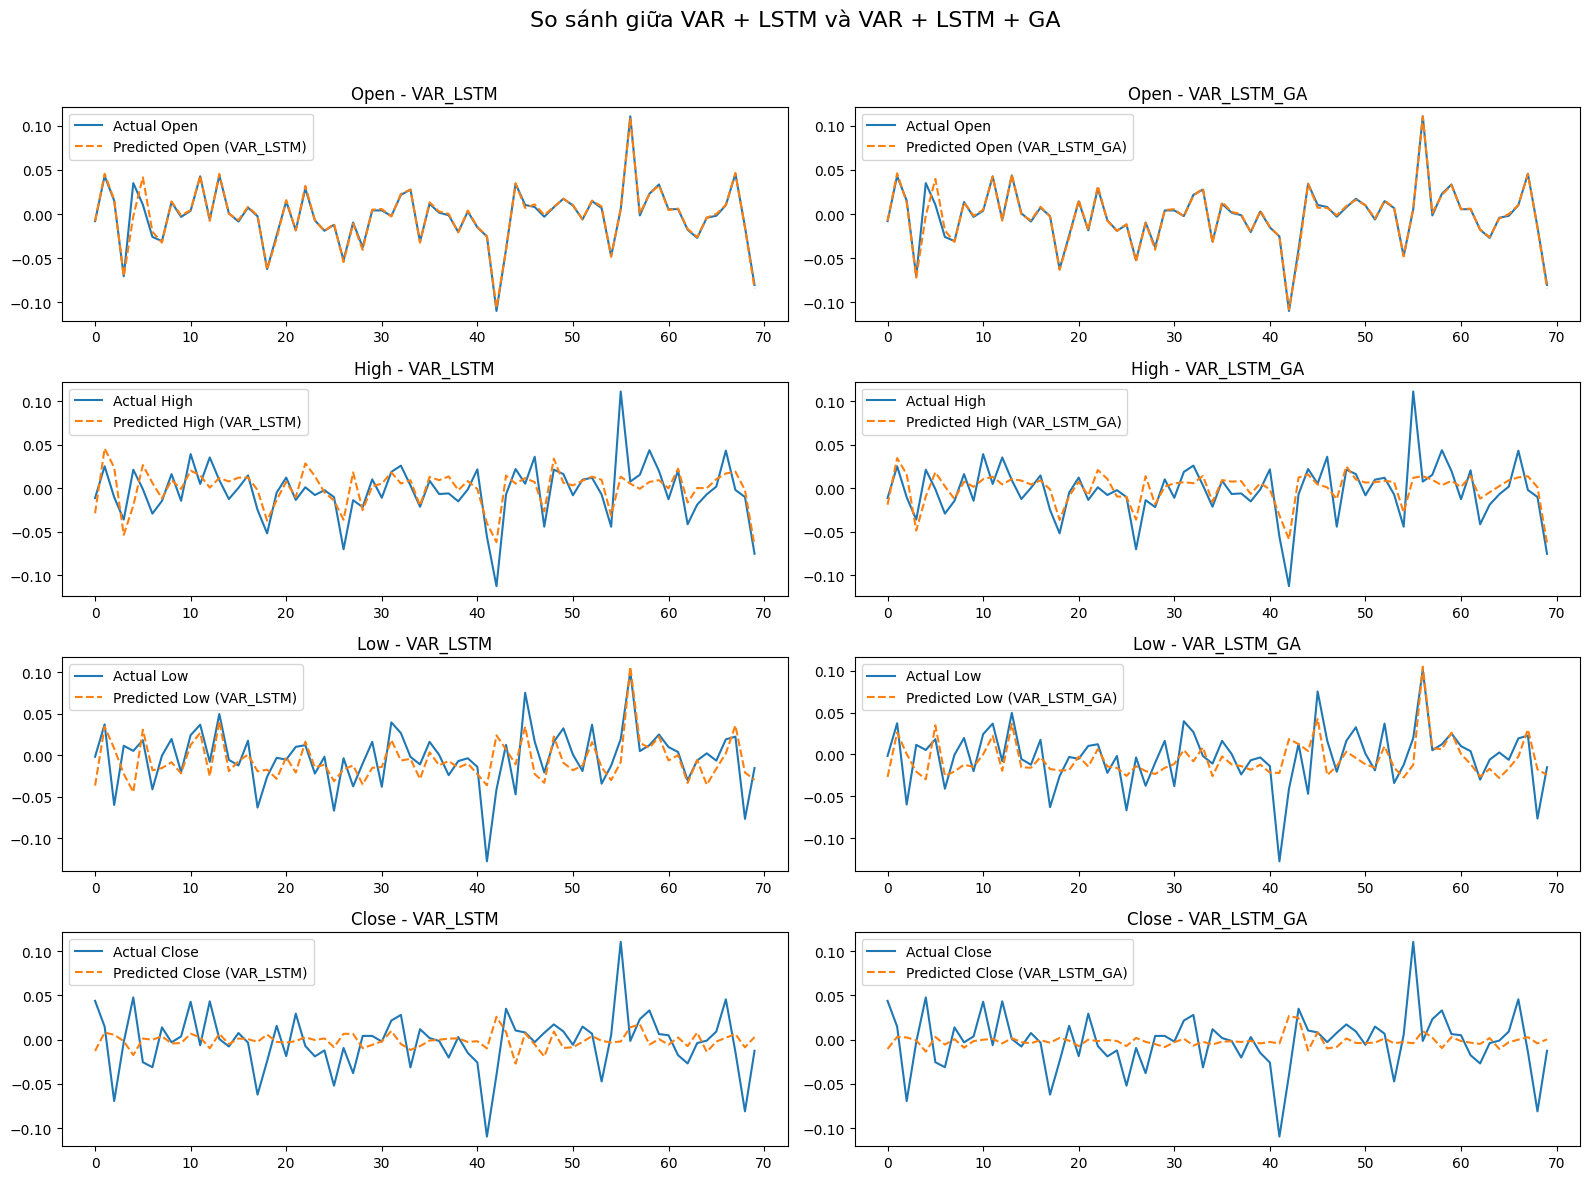

In [49]:
# Dự đoán từ mô hình Default LSTM
test_predict_default = model_default.predict(X_test)

# Dự đoán từ mô hình GA LSTM
test_predict_ga = final_model.predict(X_test)

# Vẽ 8 biểu đồ để so sánh
plt.figure(figsize=(16, 12))

# Thêm tiêu đề chung cho tất cả các biểu đồ
plt.suptitle('So sánh giữa VAR + LSTM và VAR + LSTM + GA', fontsize=16)

# Biểu đồ 1: So sánh Open của Default LSTM
plt.subplot(4, 2, 1)
plt.plot(y_test[:, 0], label='Actual Open')  # Cột Open
plt.plot(test_predict_default[:, 0], label='Predicted Open (VAR_LSTM)', linestyle='dashed')
plt.title('Open - VAR_LSTM')
plt.legend()

# Biểu đồ 2: So sánh Open của GA LSTM
plt.subplot(4, 2, 2)
plt.plot(y_test[:, 0], label='Actual Open')
plt.plot(test_predict_ga[:, 0], label='Predicted Open (VAR_LSTM_GA)', linestyle='dashed')
plt.title('Open - VAR_LSTM_GA')
plt.legend()

# Biểu đồ 3: So sánh High của Default LSTM
plt.subplot(4, 2, 3)
plt.plot(y_test[:, 1], label='Actual High')  # Cột High
plt.plot(test_predict_default[:, 1], label='Predicted High (VAR_LSTM)', linestyle='dashed')
plt.title('High - VAR_LSTM')
plt.legend()

# Biểu đồ 4: So sánh High của GA LSTM
plt.subplot(4, 2, 4)
plt.plot(y_test[:, 1], label='Actual High')
plt.plot(test_predict_ga[:, 1], label='Predicted High (VAR_LSTM_GA)', linestyle='dashed')
plt.title('High - VAR_LSTM_GA')
plt.legend()

# Biểu đồ 5: So sánh Low của Default LSTM
plt.subplot(4, 2, 5)
plt.plot(y_test[:, 2], label='Actual Low')  # Cột Low
plt.plot(test_predict_default[:, 2], label='Predicted Low (VAR_LSTM)', linestyle='dashed')
plt.title('Low - VAR_LSTM')
plt.legend()

# Biểu đồ 6: So sánh Low của GA LSTM
plt.subplot(4, 2, 6)
plt.plot(y_test[:, 2], label='Actual Low')
plt.plot(test_predict_ga[:, 2], label='Predicted Low (VAR_LSTM_GA)', linestyle='dashed')
plt.title('Low - VAR_LSTM_GA')
plt.legend()

# Biểu đồ 7: So sánh Close của Default LSTM
plt.subplot(4, 2, 7)
plt.plot(y_test[:, 3], label='Actual Close')  # Cột Close
plt.plot(test_predict_default[:, 3], label='Predicted Close (VAR_LSTM)', linestyle='dashed')
plt.title('Close - VAR_LSTM')
plt.legend()

# Biểu đồ 8: So sánh Close của GA LSTM
plt.subplot(4, 2, 8)
plt.plot(y_test[:, 3], label='Actual Close')
plt.plot(test_predict_ga[:, 3], label='Predicted Close (VAR_LSTM_GA)', linestyle='dashed')
plt.title('Close - VAR_LSTM_GA')
plt.legend()

# Điều chỉnh bố cục để các biểu đồ không bị chồng chéo
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Khoảng cách với tiêu đề chung

plt.show()


#### 9.2 Kết luận so sánh

In [50]:
# Tính sự khác biệt giữa các tham số của GA và LSTM mặc định
rmse_diff = rmse_best - rmse_default
mse_diff = mse_best - mse_default
mae_diff = mae_best - mae_default

# In sự khác biệt
print(f'RMSE Difference: {rmse_diff}')
print(f'MSE Difference: {mse_diff}')
print(f'MAE Difference: {mae_diff}')

# Đưa ra kết luận dựa trên sự khác biệt
if rmse_diff < 0 and mse_diff < 0 and mae_diff < 0:
    print("Kết luận: Mô hình VAR kết hợp LSTM với tham số tối ưu từ GA cho kết quả tốt hơn so với VAR kết hợp LSTM mặc định.")
elif rmse_diff > 0 and mse_diff > 0 and mae_diff > 0:
    print("Kết luận: Mô hình VAR kết hợp LSTM với tham số tối ưu từ GA cho kết quả kém hơn mô hình VAR kết hợp LSTM mặc định.")
else:
    print("Kết luận: Mô hình VAR kết hợp LSTM với tham số tối ưu từ GA có sự cải thiện ở một số chỉ số nhưng không hoàn toàn vượt trội so với mô hình LSTM mặc định.")


RMSE Difference: -0.00014641921409129857
MSE Difference: -7.067675195893152e-06
MAE Difference: -0.0003322907151553957
Kết luận: Mô hình VAR kết hợp LSTM với tham số tối ưu từ GA cho kết quả tốt hơn so với VAR kết hợp LSTM mặc định.


### 10. Dự đoán giá Bitcoin

#### 10.1. Phục hồi giá trị dự đoán về dạng gốc để dễ hình dung

In [51]:
def inverse_transform_predictions(predictions, original_data):
    """
    Hồi phục giá trị dự đoán về dạng gốc
    """
    # 1. Hồi phục từ log transformation
    predictions_exp = np.exp(predictions) - 1
    
    # 2. Hồi phục từ differencing
    predictions_restored = {}
    columns = ['Open', 'High', 'Low', 'Close']
    
    for i, col in enumerate(columns):
        # Lấy giá trị cuối cùng của dữ liệu gốc làm base
        last_value = original_data[col].iloc[-1]
        
        # Tính giá trị tích lũy từ điểm cuối
        cumulative_changes = np.cumsum(predictions_exp[:, i])
        predictions_restored[col] = last_value * (1 + cumulative_changes)
        
        # Đảm bảo giá trị hợp lý
        if np.any(predictions_restored[col] < 0):
            print(f"Cảnh báo: Điều chỉnh giá trị âm trong cột {col}")
            predictions_restored[col] = np.maximum(predictions_restored[col], 0)
    
    # 3. Tạo DataFrame kết quả
    predictions_df = pd.DataFrame(predictions_restored)
    
    # 4. Tạo index thời gian mới
    last_date = original_data.index[-1]
    new_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1), 
        periods=len(predictions_df), 
        freq='D'
    )
    predictions_df.index = new_dates
    
    # 5. Đảm bảo logic giá High/Low
    predictions_df['High'] = np.maximum(
        predictions_df[['Open', 'High', 'Close']].max(axis=1),
        predictions_df['High']
    )
    predictions_df['Low'] = np.minimum(
        predictions_df[['Open', 'Low', 'Close']].min(axis=1),
        predictions_df['Low']
    )
    
    return predictions_df

#### 10.2 Biểu đồ dự đoán giá

In [52]:
def evaluate_predictions(predictions_df, original_data, n_display=5):
    """
    Hiển thị và đánh giá kết quả dự đoán
    """
    print("1. Các giá trị dự đoán đầu tiên:")
    print(predictions_df.head(n_display))
    
    print("\n2. Thống kê mô tả:")
    print(predictions_df.describe())
    
    print("\n3. Phần trăm thay đổi giá:")
    pct_change = predictions_df.pct_change().describe()
    print(pct_change)
    
    # Vẽ biểu đồ
    plt.figure(figsize=(15, 10))
    
    # Plot 1: So sánh giá Open
    plt.subplot(2, 1, 1)
    plt.plot(original_data['Open'][-30:], label='Actual Open', color='blue')
    plt.plot(predictions_df['Open'][:30], label='Predicted Open', color='red', linestyle='--')
    plt.title('So sánh giá Open thực tế và dự đoán')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Tất cả các giá dự đoán
    plt.subplot(2, 1, 2)
    plt.plot(predictions_df['High'][:30], label='High', color='green', alpha=0.7)
    plt.plot(predictions_df['Open'][:30], label='Open', color='blue', alpha=0.7)
    plt.plot(predictions_df['Close'][:30], label='Close', color='black', alpha=0.7)
    plt.plot(predictions_df['Low'][:30], label='Low', color='red', alpha=0.7)
    plt.fill_between(predictions_df.index[:30], 
                     predictions_df['Low'][:30], 
                     predictions_df['High'][:30], 
                     alpha=0.2, color='gray')
    plt.title('Dự đoán OHLC')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Kiểm tra logic giá
    invalid_days = predictions_df[predictions_df['Low'] > predictions_df['High']].index
    if len(invalid_days) > 0:
        print("\nCảnh báo: Các ngày có giá Low > High:")
        print(invalid_days)
    
    # Tính toán độ biến động
    volatility = predictions_df['Close'].pct_change().std() * np.sqrt(252) * 100
    print(f"\nĐộ biến động hàng năm của giá dự đoán: {volatility:.2f}%")



1. Các giá trị dự đoán đầu tiên:
                    Open          High           Low         Close
2022-02-20  39714.625000  39714.625000  38949.503906  39707.871094
2022-02-21  41608.972656  41608.972656  39830.886719  39830.886719
2022-02-22  42135.679688  42135.679688  39932.441406  39932.441406
2022-02-23  39360.175781  39901.042969  39217.300781  39901.042969
2022-02-24  39291.488281  39361.261719  38044.785156  39361.261719

2. Thống kê mô tả:
               Open          High           Low         Close
count     70.000000     70.000000     70.000000     70.000000
mean   36880.203125  40863.484375  30170.681641  37332.167969
std     3727.522217   1263.736572   5437.347168   1296.972046
min    28553.531250  37678.054688  22397.640625  35418.621094
25%    35172.566406  39981.558594  25378.263184  36276.872070
50%    36792.373047  40914.677734  28437.203125  37006.566406
75%    39482.655273  41630.722656  35937.623047  38417.867188
max    42909.480469  43536.941406  39932.441406  

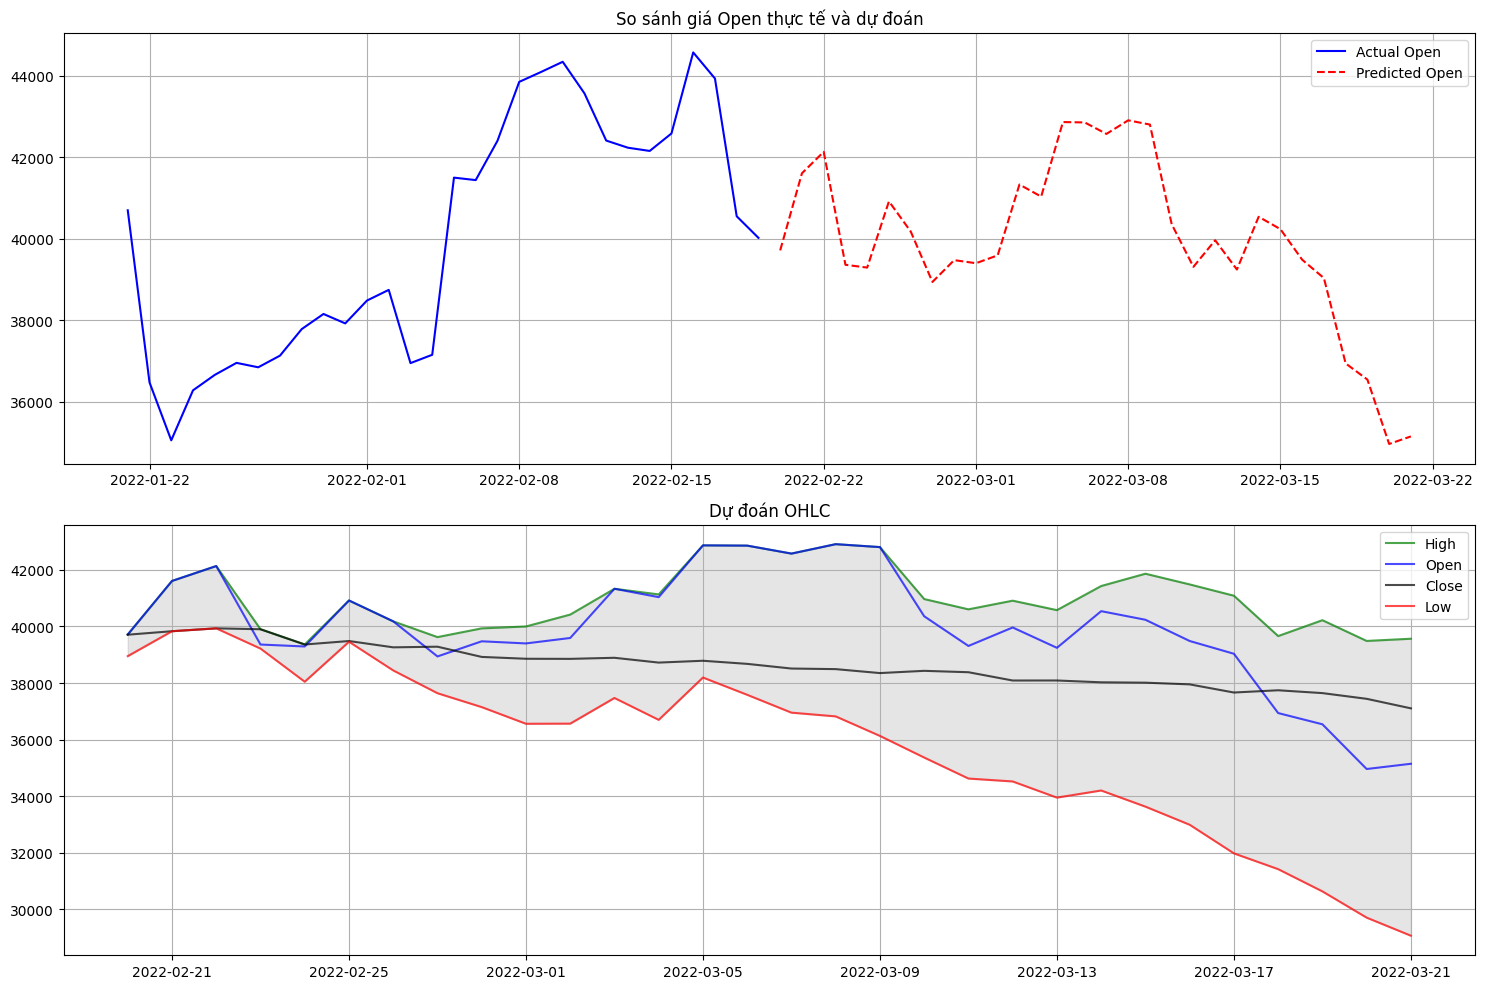


Độ biến động hàng năm của giá dự đoán: 11.09%


In [53]:
# Sử dụng functions đã sửa
predictions_restored = inverse_transform_predictions(predictions, dfOneYear)
evaluate_predictions(predictions_restored, dfOneYear)

#### 10.3. In giá trị dự đoán cho Open, High, Low, Close

In [54]:
# In giá trị dự đoán cho Open
print("\n=== OPEN PREDICTIONS ===")
print("Ngày\t\t\tGiá Open")
print("-" * 40)
for date, value in predictions_restored['Open'].head(10).items():
    print(f"{date.strftime('%Y-%m-%d')}\t{value:.2f}")

# In giá trị dự đoán cho High
print("\n=== HIGH PREDICTIONS ===")
print("Ngày\t\t\tGiá High")
print("-" * 40)
for date, value in predictions_restored['High'].head(10).items():
    print(f"{date.strftime('%Y-%m-%d')}\t{value:.2f}")




=== OPEN PREDICTIONS ===
Ngày			Giá Open
----------------------------------------
2022-02-20	39714.62
2022-02-21	41608.97
2022-02-22	42135.68
2022-02-23	39360.18
2022-02-24	39291.49
2022-02-25	40918.32
2022-02-26	40179.82
2022-02-27	38938.77
2022-02-28	39474.74
2022-03-01	39398.99

=== HIGH PREDICTIONS ===
Ngày			Giá High
----------------------------------------
2022-02-20	39714.62
2022-02-21	41608.97
2022-02-22	42135.68
2022-02-23	39901.04
2022-02-24	39361.26
2022-02-25	40918.32
2022-02-26	40179.82
2022-02-27	39623.38
2022-02-28	39931.90
2022-03-01	39999.34


In [55]:
# In giá trị dự đoán cho Low
print("\n=== LOW PREDICTIONS ===")
print("Ngày\t\t\tGiá Low")
print("-" * 40)
for date, value in predictions_restored['Low'].head(10).items():
    print(f"{date.strftime('%Y-%m-%d')}\t{value:.2f}")

# In giá trị dự đoán cho Close
print("\n=== CLOSE PREDICTIONS ===")
print("Ngày\t\t\tGiá Close")
print("-" * 40)
for date, value in predictions_restored['Close'].head(10).items():
    print(f"{date.strftime('%Y-%m-%d')}\t{value:.2f}")



=== LOW PREDICTIONS ===
Ngày			Giá Low
----------------------------------------
2022-02-20	38949.50
2022-02-21	39830.89
2022-02-22	39932.44
2022-02-23	39217.30
2022-02-24	38044.79
2022-02-25	39458.92
2022-02-26	38444.46
2022-02-27	37638.86
2022-02-28	37147.66
2022-03-01	36558.36

=== CLOSE PREDICTIONS ===
Ngày			Giá Close
----------------------------------------
2022-02-20	39707.87
2022-02-21	39830.89
2022-02-22	39932.44
2022-02-23	39901.04
2022-02-24	39361.26
2022-02-25	39484.01
2022-02-26	39260.91
2022-02-27	39283.63
2022-02-28	38922.12
2022-03-01	38856.96


In [56]:
# Hiển thị toàn bộ dữ liệu trong predictions_restored
print("\nShape của predictions_restored:", predictions_restored.shape)
print("\nThông tin về DataFrame:")
print(predictions_restored.info())
print("\nMô tả thống kê:")
print(predictions_restored.describe())
print("\nDữ liệu chi tiết:")
print(predictions_restored)

# Hoặc xuất ra file CSV để dễ xem hơn
predictions_restored.to_csv('predictions_restored.csv')


Shape của predictions_restored: (70, 4)

Thông tin về DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2022-02-20 to 2022-04-30
Freq: D
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    70 non-null     float32
 1   High    70 non-null     float32
 2   Low     70 non-null     float32
 3   Close   70 non-null     float32
dtypes: float32(4)
memory usage: 1.6 KB
None

Mô tả thống kê:
               Open          High           Low         Close
count     70.000000     70.000000     70.000000     70.000000
mean   36880.203125  40863.484375  30170.681641  37332.167969
std     3727.522217   1263.736572   5437.347168   1296.972046
min    28553.531250  37678.054688  22397.640625  35418.621094
25%    35172.566406  39981.558594  25378.263184  36276.872070
50%    36792.373047  40914.677734  28437.203125  37006.566406
75%    39482.655273  41630.722656  35937.623047  38417.867188
max    42909.480469  435